In [115]:
from ppget.source import ModelSource, prepare_filesystem

WINDOW = 4
MODEL_NAME = "model/cnn1d/"

start_date = "2007-07-01"
end_date = "2008-08-06"
feature = "Global_active_power"

prepare_filesystem(MODEL_NAME)
source = ModelSource.load(start_date, end_date, feature)
source.missing_data()

Series([], Freq: 10T, Name: Global_active_power, dtype: float64)

In [116]:
series = source.series()
series.describe()

count    57888.000000
mean         1.088116
std          1.051975
min          0.078000
25%          0.294200
50%          0.591100
75%          1.548200
max          8.514600
Name: Global_active_power, dtype: float64

In [117]:
from ppget.training import DatasetBuilder, TrainSplit

builder = DatasetBuilder(series, data_split=TrainSplit(), window_size=WINDOW)

S = builder.build_splits()

S["training"]["X"].shape, S["training"]["y"].shape, S["test"]["X"].shape, S["test"]["y"].shape

((52095, 4, 1), (52095,), (5789, 4, 1), (5789,))

In [118]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Dense, Conv1D, Flatten, Dropout
from tensorflow.python.keras.metrics import RootMeanSquaredError
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential()
model.add(InputLayer((WINDOW, 1)))
model.add(Conv1D(8, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dense(4, 'relu'))
model.add(Dense(1, 'linear'))
callbacks = [ModelCheckpoint(MODEL_NAME, monitor="val_loss", save_best_only=True, mode="min"), EarlyStopping(patience=4, monitor="val_loss")]
model.compile(loss="mse", optimizer="adam", metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 3, 8)              24        
_________________________________________________________________
flatten_12 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 4)                 100       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 5         
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


In [119]:
%%time
h = model.fit(S["training"]["X"], S["training"]["y"],
                    epochs=100,
                    batch_size=16,
                    validation_split=0.2,
                    verbose=2,
                    callbacks=callbacks)
print(f"min RMSE(validation): {min(h.history['val_loss'])}")

Epoch 1/100
2605/2605 - 3s - loss: 0.0055 - root_mean_squared_error: 0.0743 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0597
INFO:tensorflow:Assets written to: model/cnn1d/assets
Epoch 2/100
2605/2605 - 2s - loss: 0.0038 - root_mean_squared_error: 0.0616 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0591
INFO:tensorflow:Assets written to: model/cnn1d/assets
Epoch 3/100
2605/2605 - 2s - loss: 0.0037 - root_mean_squared_error: 0.0612 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0597
Epoch 4/100
2605/2605 - 4s - loss: 0.0037 - root_mean_squared_error: 0.0612 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0596
Epoch 5/100
2605/2605 - 4s - loss: 0.0037 - root_mean_squared_error: 0.0610 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0599
Epoch 6/100
2605/2605 - 4s - loss: 0.0037 - root_mean_squared_error: 0.0610 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0594
min RMSE(validation): 0.0034909769892692566
CPU times: user 24.3 s, sys: 3.04 s, total: 27.3 s

In [120]:
%%time
from tensorflow.python.keras.models import load_model

model = load_model(MODEL_NAME)

predictions = model.predict(S["test"]["X"]).flatten()
len(predictions)

CPU times: user 612 ms, sys: 34.3 ms, total: 647 ms
Wall time: 624 ms


5789

In [121]:
import pandas as pd

test_results = pd.DataFrame(data={"Predictions": predictions, "Ground Truth": S["test"]["y"]})
test_results.head()

,Predictions,Ground Truth
0,0.174344,0.223336
1,0.213204,0.103952
2,0.084506,0.032003
3,0.037970,0.104497
4,0.134765,0.205604


In [122]:
from ppget.metrics import ModelEvaluation

print(ModelEvaluation(expected=test_results["Ground Truth"][:-1],
                      predicted=test_results["Predictions"].shift(-1)[:-1],
                      m=1,
                      model_path=MODEL_NAME,
                      builder=builder))

Model Scores - (R2): 0.963, (Adj R2): 0.963, (RMSE): 0.219 KW. Model Size - 121628 bytes.


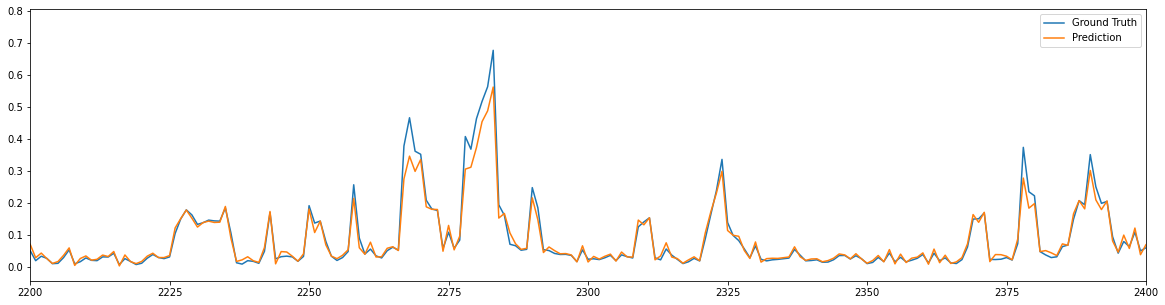

In [123]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,5))
ax.plot(test_results["Ground Truth"], label="Ground Truth")
ax.plot(test_results["Predictions"].shift(-1), label="Prediction")

plt.legend(["Ground Truth", "Prediction"])
plt.xlim([2200, 2400])
plt.show()